In [1]:
import sys
sys.path.append("../../../../../src")
sys.path.append("../")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

from tqdm import tqdm
from scipy.interpolate import interp1d

%matplotlib inline

plt.style.use(["science","bright","grid"])

In [2]:
N_voltages              = 1000
topology_parameter      = {
    "Nx"                : 2,
    "Ny"                : 1,
    "Nz"                : 1,
    "e_pos"             : [[0,0,0],[2-1,0,0]],
    "electrode_type"    : ['constant','constant']
}
time_steps, voltages    = nanonets_utils.sinusoidal_voltages(N_samples=N_voltages, topology_parameter=topology_parameter,
                                                                    amplitudes=0.1, frequencies=2e5, time_step=1e-7)

## String

In [3]:
time_step       = 1e-7
radius          = 1e6
# radius          = 10.0
eq_step         = 800
N_min, N_max    = 2, 12
N_vals          = np.arange(N_min, N_max)
# path            = '/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/alternating_current/'
# path            = '/home/jonasmensing/phd/data/2_funding_period/potential/magic_cable/alternating_current/'
path            = '/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/alternating_current/'
data_string     = {N : pd.read_csv(f"{path}Nx={N}_Ny=1_Nz=1_Ne=2_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in N_vals}
states_string   = {N : pd.read_csv(f"{path}mean_state_Nx={N}_Ny=1_Nz=1_Ne=2_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in N_vals}
currents_string = {N : pd.read_csv(f"{path}net_currents_Nx={N}_Ny=1_Nz=1_Ne=2_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in N_vals}
t_vals          = np.arange(len(data_string[2]))*time_step*1e6
x_vals          = data_string[2]['E0'].values*1000

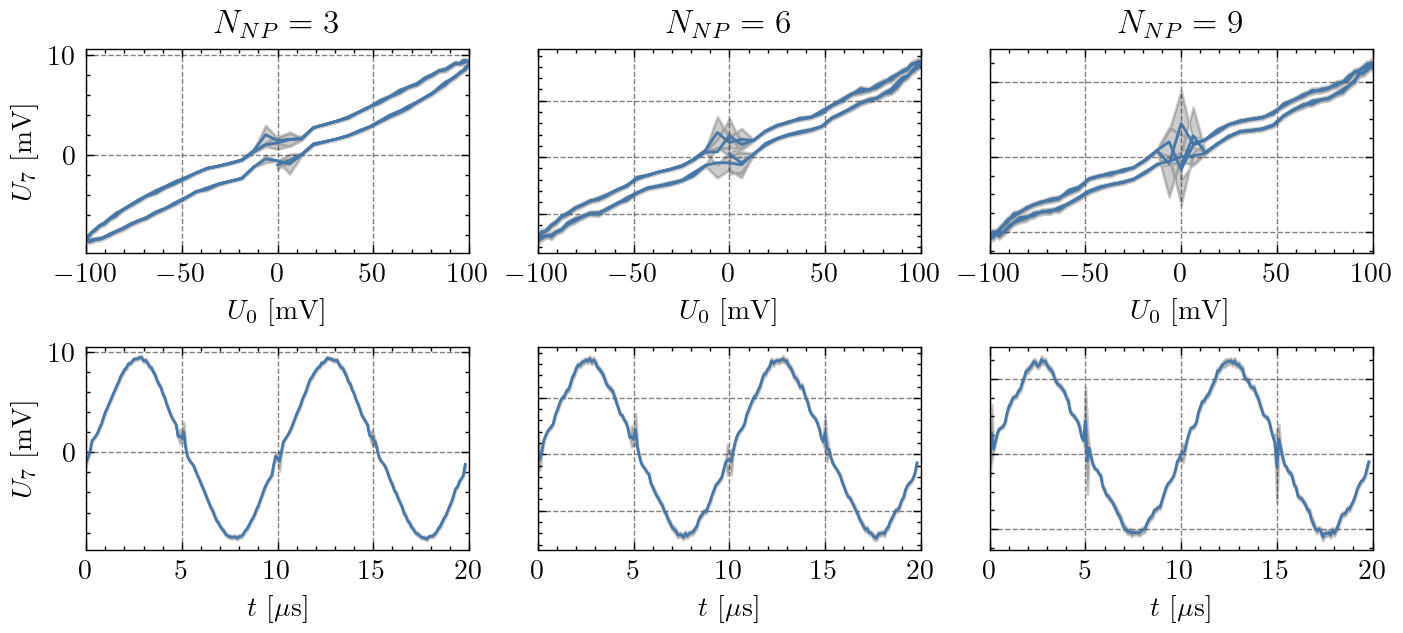

In [66]:
N_vals_new  = [3,6,9]
N_rows      = 2
N_cols      = len(N_vals_new)
fig         = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*1.2)
fig.set_figwidth(fig.get_figwidth()*2)

for i, N in enumerate(N_vals_new):

    ax      = fig.add_subplot(N_rows, N_cols, i+1)
    val     = data_string[N]['Current'].values*1000
    val_e   = data_string[N]['Error'].values*1000

    ax.plot(x_vals, val)
    ax.fill_between(x_vals, val-val_e, val+val_e, color='black', alpha=0.2)

    ax.set_xlim(-100,100)
    ax.set_title("$N_{NP} = "+f"{N}$")
    ax.set_xlabel("$U_0$ [mV]")
    # ax.set_ylim(-10,10)

    if i == 0:
        ax.set_ylabel("$U_7$ [mV]")
    else:
        ax.set_yticklabels("")

for i, N in enumerate(N_vals_new):

    ax      = fig.add_subplot(N_rows, N_cols, i+N_cols+1)
    val     = data_string[N]['Current'].values*1000
    val_e   = data_string[N]['Error'].values*1000

    ax.plot(t_vals, val)
    ax.fill_between(t_vals, val-val_e, val+val_e, color='black', alpha=0.2)

    ax.set_xlabel("$t$ [$\mu$s]")
    ax.set_xlim(0,20)

    if i == 0:
        ax.set_ylabel("$U_7$ [mV]")
    else:
        ax.set_yticklabels("")
    
# fig.savefig(f"../plots/magnitude/input_output_string_radius_{radius}.svg", bbox_inches='tight', transparent=True)
# fig.savefig(f"../plots/magnitude/input_output_string_radius_{radius}.pdf", bbox_inches='tight', transparent=False)

Text(0.5, 0.98, '$N_x = 11$, $N_y = 1$, $N_z = 1$')

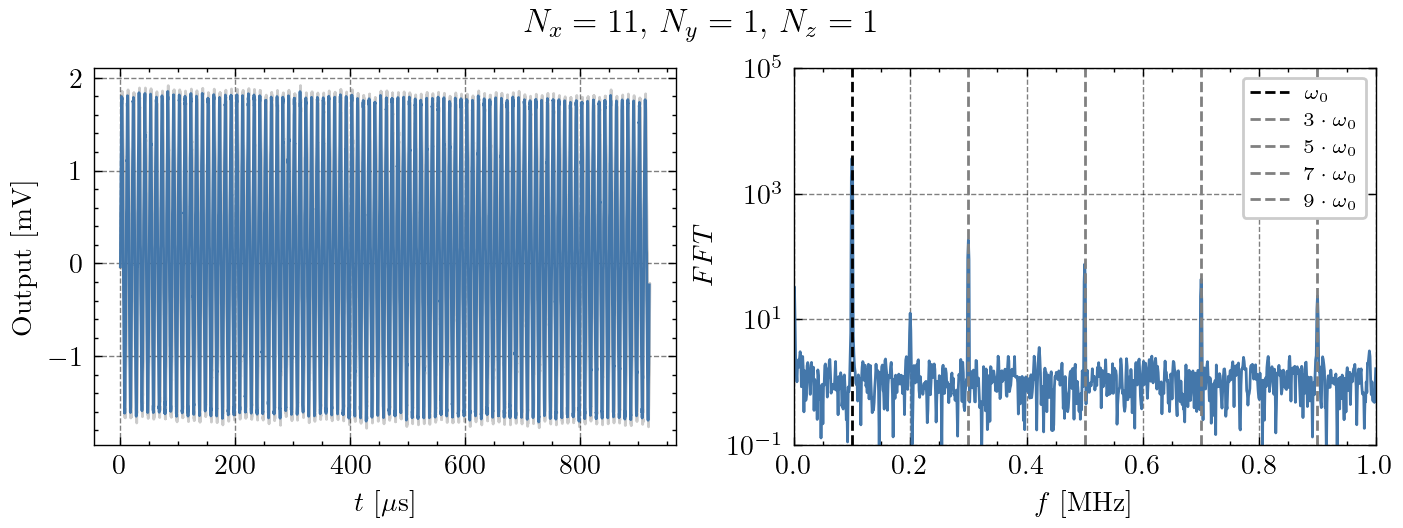

In [8]:
N_p     = 11
y_min   = 0.1
y_max   = 100000
f1      = 0.1
vals    = data_string[N_p]['Current'].values*1000
vals_e  = data_string[N_p]['Error'].values*1000

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ax.plot(t_vals, vals)
ax.fill_between(t_vals, vals-vals_e, vals+vals_e, color='black', alpha=0.2)
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_ylabel('Output [mV]')
# ax.set_xlim(0,80)

ax      = fig.add_subplot(1,2,2)
signal  = vals.copy()
signal  = signal - np.mean(signal)
xf, f   = nanonets_utils.fft(signal=signal, dt=time_step, n_padded=0)

ax.plot(xf/1e6 ,f)
ax.vlines(f1, y_min, y_max, colors='black', ls='--', label='$\omega_0$')
ax.vlines(3*f1, y_min, y_max, colors='grey', ls='--', label='$3 \cdot \omega_0$')
ax.vlines(5*f1, y_min, y_max, colors='grey', ls='--', label='$5 \cdot \omega_0$')
ax.vlines(7*f1, y_min, y_max, colors='grey', ls='--', label='$7 \cdot \omega_0$')
ax.vlines(9*f1, y_min, y_max, colors='grey', ls='--', label='$9 \cdot \omega_0$')
ax.set_xlim(0,1)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("$f$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_yscale('log')
ax.legend(ncol=1, frameon=True, fontsize='x-small', framealpha=1, loc='upper right')
fig.suptitle(f'$N_x = {N_p}$, $N_y = 1$, $N_z = 1$')
# fig.savefig(f"../plots/radius_{radius}/{N_p}_string_output_fft.svg", bbox_inches='tight', transparent=True)
# fig.savefig(f"../plots/radius_{radius}/{N_p}_string_output_fft.pdf", bbox_inches='tight', transparent=False)

In [9]:
f0              = 1e5
harmonics       = []

for key, df in data_string.items():

    signal          = df['Current'].values*1000
    arr_strength    = nanonets_utils.harmonic_strength(signal=signal, f0=f0, dt=time_step, N_f=10, dB=False)
    harmonics.append(arr_strength)

thd_string  = np.sqrt(np.sum(np.array(harmonics)**2, axis=1))

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, '2'),
  Text(0, 1.5, '3'),
  Text(0, 2.5, '4'),
  Text(0, 3.5, '5'),
  Text(0, 4.5, '6'),
  Text(0, 5.5, '7'),
  Text(0, 6.5, '8'),
  Text(0, 7.5, '9'),
  Text(0, 8.5, '10'),
  Text(0, 9.5, '11')])

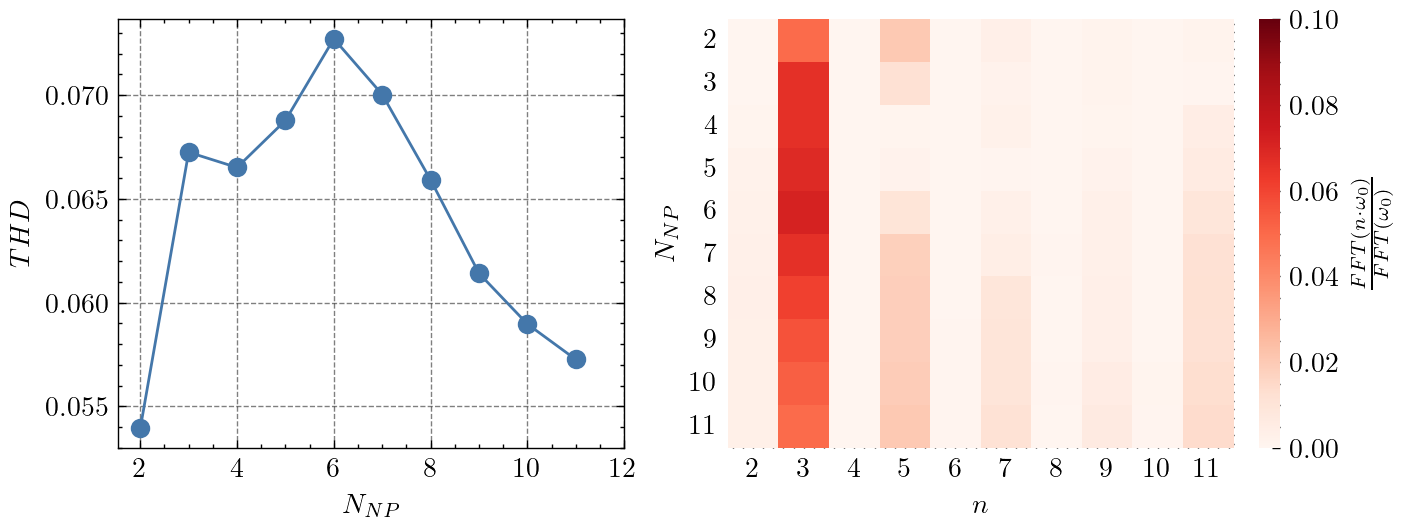

In [10]:
colormap    = 'Reds'
cmap        = plt.get_cmap(colormap)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

ax  = fig.add_subplot(1,2,1)
ax.plot(N_vals, thd_string, 'o-')
ax.set_xlabel("$N_{NP}$")
ax.set_xticks(np.arange(N_min,N_max+1,2))
ax.set_ylabel("$THD$")

df  = pd.DataFrame(harmonics, index=N_vals, columns=np.arange(2, len(arr_strength)+2))
ax  = fig.add_subplot(1,2,2)
ax  = sns.heatmap(df, cmap='Reds', cbar_kws={"label":"$\\frac{FFT(n \cdot \omega_0)}{FFT(\omega_0)}$"},
                  vmin=0, vmax=0.1)

ax.set_ylabel("$N_{NP}$")
ax.set_xlabel("$n$")
plt.yticks(rotation=0)

# fig.savefig(f"../plots/radius_{radius}/THD_string_sample.svg", bbox_inches='tight', transparent=True)
# fig.savefig(f"../plots/radius_{radius}/THD_string_sample.pdf", bbox_inches='tight', transparent=False)

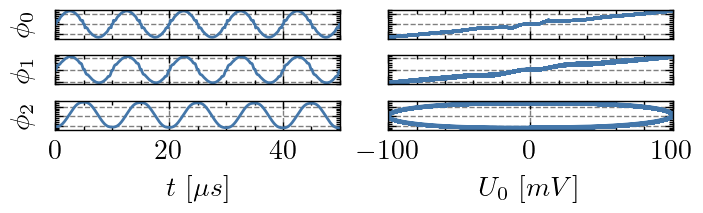

In [11]:
N_val   = 2
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*2*N_val/10)

for i in range(N_val+1):

    ax  = fig.add_subplot(N_val+1,2,2*i+1)
    arr = states_string[N_val][f"{i}"]
    ax.plot(t_vals, arr)

    ax.set_ylabel("$\phi_{"+f"{i}"+"}$")
    ax.set_xlim(0,50)
    ax.set_yticklabels("")
    if (i < N_val):
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$t$ [$\mu s$]")

    ax  = fig.add_subplot(N_val+1,2,2*i+2)
    ax.plot(x_vals, arr)
    ax.set_yticklabels("")
    ax.set_xlim(-100,100)
    if (i < N_val):
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$U_0$ [$mV$]")
    # fig.savefig(f"../plots/radius_{radius}/{N_val}_string_np_responses.svg", bbox_inches='tight', transparent=True)
    # fig.savefig(f"../plots/radius_{radius}/{N_val}_string_np_responses.pdf", bbox_inches='tight', transparent=False)

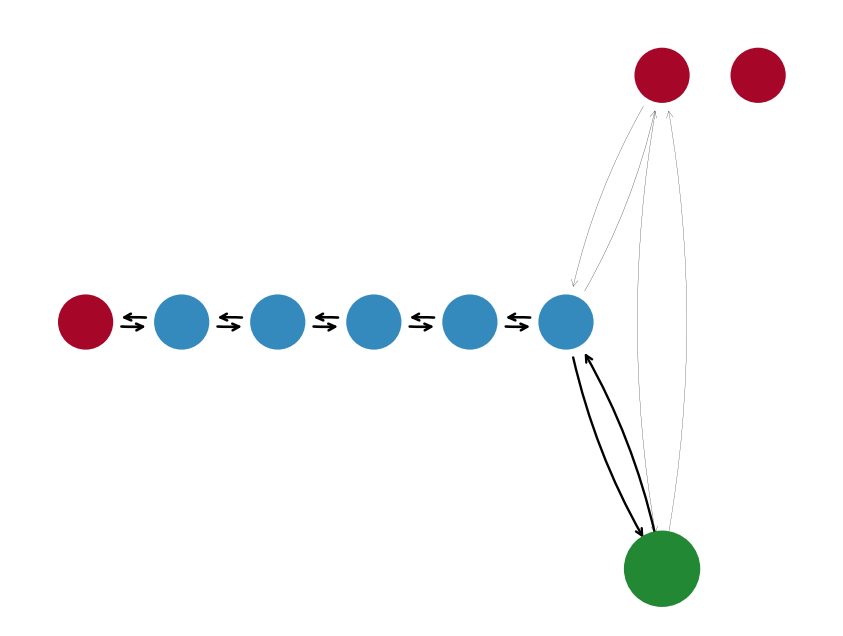

In [12]:
N   = 5
df  = currents_string[N]
G   = nx.DiGraph()
G.add_nodes_from(np.arange(N+3))
x   = [(eval(col)[0],eval(col)[1], df[col][:100].mean()) for col in df.columns]
G.add_weighted_edges_from(x)

weights     = 0.5*np.array([G[u][v]['weight'] for u, v in G.edges()])*1e8
pos         = {i+2 : [i+1,0] for i in range(N)}
pos[0]      = [0,0]
pos[1]      = [N+2,0.5]
pos[N+2]    = [N+1,-0.5]
pos[N+3]    = [N+1,0.5]
colors      = [nanonets_utils.red_color,nanonets_utils.red_color] + [nanonets_utils.blue_color for i in range(N)] + [nanonets_utils.green_color,nanonets_utils.red_color]
np_size     = 150
sizes       = np.repeat(np_size,N+4)
sizes[N+2]  = 2*np_size

fig, ax = plt.subplots(dpi=300)
nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors, node_size=sizes)
# nx.draw_networkx_labels(G, pos, ax=ax)
nx.draw_networkx_edges(G, pos, width=weights, arrowsize=4, arrowstyle='->', connectionstyle='arc3,rad=0.1', ax=ax)
ax.axis('off')
ax.grid(False)

## Network

In [70]:
# radius          = 10.0
radius          = 1000000.0
data_network    = {N : pd.read_csv(f"{path}Nx={N}_Ny={N}_Nz=1_Ne=8_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in [3,5,7,9,11,13]}
states_network  = {N : 1000*pd.read_csv(f"{path}mean_state_Nx={N}_Ny={N}_Nz=1_Ne=8_{radius}.csv").loc[eq_step:,:].reset_index(drop=True) for N in [3,5,7,9,11,13]}

In [71]:
f0              = 1e5
harmonics       = []

for key, df in data_network.items():

    signal          = df['Current'].values*1000
    arr_strength    = nanonets_utils.harmonic_strength(signal=signal, f0=f0, dt=time_step, N_f=10, dB=False)
    harmonics.append(arr_strength)

thd_network  = np.sqrt(np.sum(np.array(harmonics)**2, axis=1))

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, '9'),
  Text(0, 1.5, '25'),
  Text(0, 2.5, '49'),
  Text(0, 3.5, '81'),
  Text(0, 4.5, '121'),
  Text(0, 5.5, '169')])

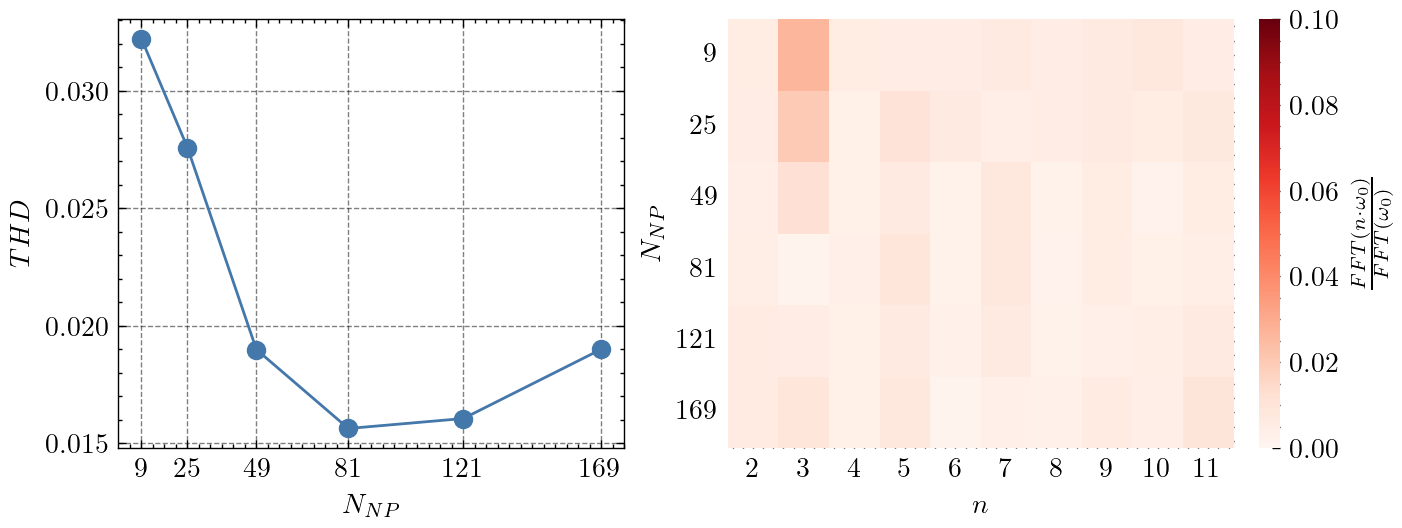

In [72]:
colormap    = 'Reds'
cmap        = plt.get_cmap(colormap)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

ax  = fig.add_subplot(1,2,1)
ax.plot(np.array([3,5,7,9,11,13])**2, thd_network, 'o-')
ax.set_xlabel("$N_{NP}$")
ax.set_xticks(np.array([3,5,7,9,11,13])**2)
ax.set_ylabel("$THD$")

df  = pd.DataFrame(harmonics, index=np.array([3,5,7,9,11,13])**2, columns=np.arange(2, len(arr_strength)+2))
ax  = fig.add_subplot(1,2,2)
ax  = sns.heatmap(df, cmap='Reds', cbar_kws={"label":"$\\frac{FFT(n \cdot \omega_0)}{FFT(\omega_0)}$"},
                  vmin=0, vmax=0.1)

ax.set_ylabel("$N_{NP}$")
ax.set_xlabel("$n$")
plt.yticks(rotation=0)

# fig.savefig(f"../plots/radius_{radius}/THD_network_sample.svg", bbox_inches='tight', transparent=True)
# fig.savefig(f"../plots/radius_{radius}/THD_network_sample.pdf", bbox_inches='tight', transparent=False)

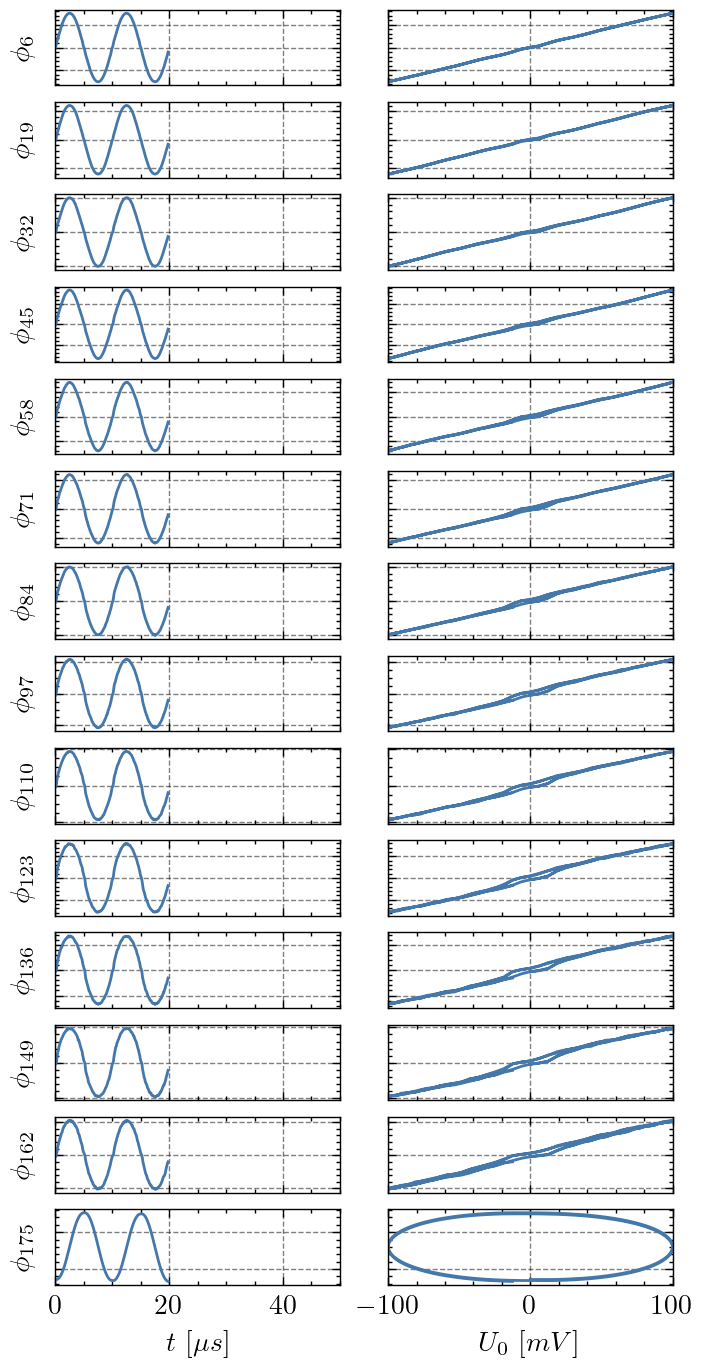

In [73]:
N_val   = 13
idx     = N_val//2
phi     = [states_network[N_val][f"{idx+i*N_val}"].values for i in range(N_val)]
phi.append(states_network[N_val][f"{N_val**2}"].values)

fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*2*N_val/10)

for i, arr in enumerate(phi):

    ax  = fig.add_subplot(N_val+1,2,2*i+1)
    ax.plot(t_vals, arr)

    ax.set_ylabel("$\phi_{"+f"{idx+i*N_val}"+"}$")
    ax.set_xlim(0,50)
    ax.set_yticklabels("")
    if (i < N_val):
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$t$ [$\mu s$]")

    ax  = fig.add_subplot(N_val+1,2,2*i+2)
    ax.plot(x_vals, arr)
    ax.set_yticklabels("")
    ax.set_xlim(-100,100)
    if (i < N_val):
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("$U_0$ [$mV$]")
        
    # fig.savefig(f"../plots/radius_{radius}/{N_val}_network_np_responses.svg", bbox_inches='tight', transparent=True)
    # fig.savefig(f"../plots/radius_{radius}/{N_val}_network_np_responses.pdf", bbox_inches='tight', transparent=False)

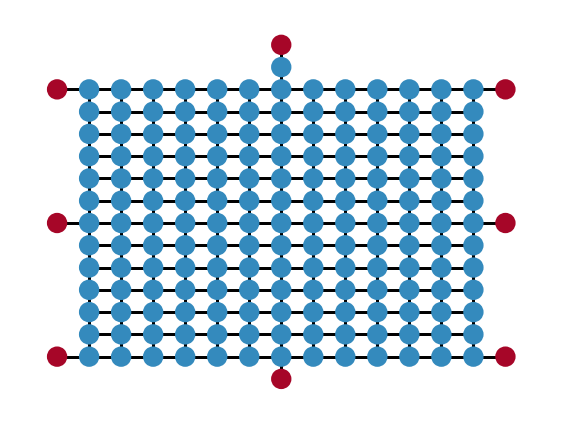

In [346]:
from system_size import return_network_topology

t_arr       = return_network_topology(N_val)
sim_class   = nanonets.simulation(t_arr)
fig, ax     = plt.subplots(dpi=200)
fig, ax     = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=40)
fig.savefig(f"../plots/{N_val}_{N_val}_network.svg", bbox_inches='tight', transparent=True)
fig.savefig(f"../plots/{N_val}_{N_val}_network.pdf", bbox_inches='tight', transparent=False)

---